In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define transform: convert to tensor + normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    # Normalizing pixel values [-1, 1]
])

# Download EMNIST Balanced split
train_set = torchvision.datasets.EMNIST(
    root='./data',
    split='balanced',
    train=True,
    download=True,
    transform=transform
)

test_set = torchvision.datasets.EMNIST(
    root='./data',
    split='balanced',
    train=False,
    download=True,
    transform=transform
)

# Dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)


100%|██████████| 562M/562M [00:03<00:00, 164MB/s]


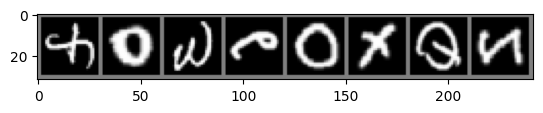

t O 3 6 0 X Q Z


In [3]:
# Class names (EMNIST Balanced has 47 classes)
classes = train_set.classes

# Function to visualize some data
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8]))
print(' '.join(f'{classes[labels[j]]}' for j in range(8)))


In [4]:
import torch.nn as nn
import torch.nn.functional as F


In [5]:
class EMNIST_CNN(nn.Module):
    def __init__(self):
        super(EMNIST_CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 47)  # 47 classes in EMNIST Balanced

        # Optional dropout to avoid overfitting
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # Convolutional layers with ReLU + Pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten
        x = x.view(-1, 64 * 7 * 7)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [6]:
# Device configuration (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Initialize model
model = EMNIST_CNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


cuda


In [7]:
# Number of epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    model.train()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # EMNIST images are rotated, let's fix that
        images = images.permute(0, 1, 3, 2).flip(2)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")


Epoch [1/10], Loss: 0.8662, Accuracy: 72.94%
Epoch [2/10], Loss: 0.5175, Accuracy: 82.52%
Epoch [3/10], Loss: 0.4537, Accuracy: 84.38%
Epoch [4/10], Loss: 0.4132, Accuracy: 85.48%
Epoch [5/10], Loss: 0.3875, Accuracy: 86.42%
Epoch [6/10], Loss: 0.3618, Accuracy: 86.98%
Epoch [7/10], Loss: 0.3450, Accuracy: 87.48%
Epoch [8/10], Loss: 0.3284, Accuracy: 87.89%
Epoch [9/10], Loss: 0.3174, Accuracy: 88.14%
Epoch [10/10], Loss: 0.3053, Accuracy: 88.58%


In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()  # Set model to evaluation mode

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        images = images.permute(0, 1, 3, 2).flip(2)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 87.34%


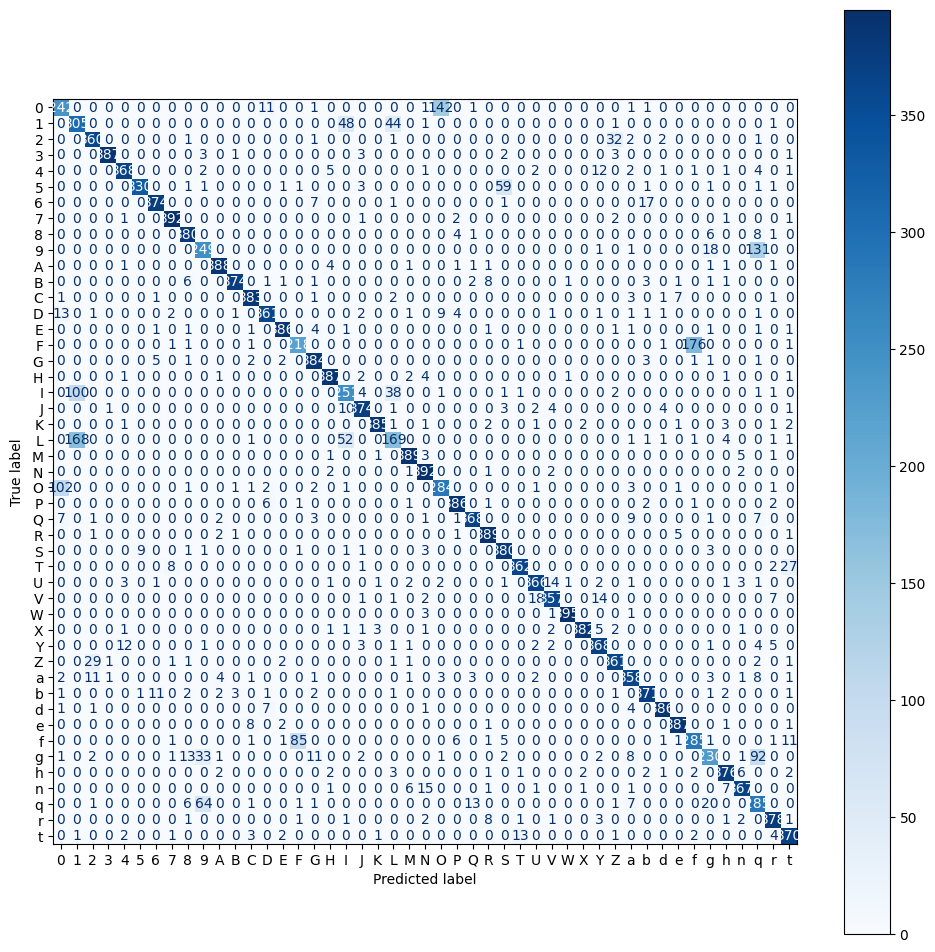

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, cmap='Blues')
plt.show()
